In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as psf
from pyspark.sql.functions import col, split, lit, when
from pyspark.sql.types import *

In [2]:
spark = SparkSession.builder.appName('events').getOrCreate()

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 144
import pandas as pd
%load_ext sql_magic
%config SQL.conn_name = 'spark'

In [4]:
df = spark.read.json('data/events/', multiLine=True)

Sample data:
{
  "hasMore": true,
  "data": [
    {
      "taskType": "Archive",
      "objectInfo": {
        "objectId": "string",
        "objectName": "string",
        "objectType": "string"
      },
      "location": "string",
      "username": "string",
      "eventSeriesId": "string",
      "eventId": "string",
      "jobInstanceId": "string",
      "status": "string",
      "slaInfo": {
        "slaId": "string",
        "slaName": "string",
        "isOnDemand": true
      },
      "startTime": "2019-08-06T22:57:08.849Z",
      "endTime": "2019-08-06T22:57:08.849Z",
      "duration": "string",
      "archiveTargetName": "string",
      "replicationSourceCluterName": "string",
      "replicationTargetLocationName": "string",
      "objectLogicalSize": 0,
      "logicalSize": 0,
      "dataTransferred": 0,
      "effectiveThroughput": 0,
      "hasJob": true,
      "dataToTransfer": 0,
      "numberOfRetries": 0,
      "estimatedTimeRemaining": "2019-08-06T22:57:08.849Z",
      "nextJobStartTime": "2019-08-06T22:57:08.849Z",
      "previousSuccessfulJobTime": "2019-08-06T22:57:08.849Z",
      "nodeIds": [
        "string"
      ],
      "isFirstFullSnapshot": true,
      "eventDate": "2019-08-06T22:57:08.849Z"
    }
  ],
  "total": 0
}

In [5]:
df.show()

+--------------------+-------+
|                data|hasMore|
+--------------------+-------+
|[[,, 90624, 21 se...|   true|
+--------------------+-------+



In [6]:
explodedDF = df.select(psf.explode(df.data))
explodedDF.take(1)

[Row(col=Row(archiveTargetName=None, dataToTransfer=None, dataTransferred=90624, duration='21 secs', effectiveThroughput=18117, endTime='2019-08-01T21:41:06.108Z', eventDate='2019-08-01T21:41:06.177Z', eventId='2019-08-01:21:4:::1564695666177-5fe9ad59-55d7-4f32-90f1-ee1adb942deb', eventSeriesId='67624a11-32f2-4be1-adb4-3170132dfd46', hasJob=True, isFirstFullSnapshot=False, jobInstanceId='MSSQL_LOG_REPLICATE_ba43af26-793d-48f5-8900-82aaab84a828:::2832', location='em2-salvbucc-w1\\MSSQLSERVER', logicalSize=90624, nextJobStartTime=None, nodeIds=['cluster:::RVM183S035507'], numberOfRetries=0, objectInfo=Row(objectId='MssqlDatabase:::764ae75f-408a-45ef-8b90-bc27c75ed9cf', objectName='AdventureWorks2014', objectType='Mssql'), objectLogicalSize=234094592, previousSuccessfulJobTime=None, replicationSourceCluterName='emea2-rbk01', replicationTargetLocationName='LOCAL', slaInfo=Row(isOnDemand=None, slaId='5226f655-e1c1-4ba7-94fb-95e2bdbb1dd3', slaName='4hr-30d-Azure'), startTime='2019-08-01T21:4

In [13]:
objectDF = explodedDF.select(explodedDF["col"].getItem('status').alias('status'),
                             explodedDF["col"].getItem('location').alias('location'),
                             explodedDF["col"].getItem('taskType').alias('taskType'),
                             explodedDF["col"].getItem('duration').alias('duration'),
                             explodedDF["col"].getItem('eventDate').alias('eventDate'),
                             explodedDF["col"].getItem('effectiveThroughput').alias('effectiveThroughput'),
                             explodedDF["col"].getItem('dataTransferred').alias('dataTransferred'),
                             explodedDF["col"].getItem('objectInfo').getItem('objectName').alias('objectName'),
                             explodedDF["col"].getItem('objectInfo').getItem('objectType').alias('objectType'))


In [14]:
objectDF.registerTempTable("table")

In [15]:
objectDF.count()

IllegalArgumentException: 'Unsupported class file major version 56'

In [28]:
%%read_sql df_result
select * from table limit 5

Query started at 04:07:16 AM PDT; Query executed in 0.00 m

,status,location,taskType,duration,eventDate,effectiveThroughput,dataTransferred,objectName,objectType
0,Success,em1-marcfern-w1.rubrikdemo.com\MSSQLSERVER,Backup,1 min 50 secs,2019-08-04T05:54:43.639Z,None,84480.0,DBTest072,Mssql
1,Success,em1-marcfern-w1.rubrikdemo.com\MSSQLSERVER,Backup,39 secs,2019-08-04T05:54:14.918Z,None,84480.0,DBTest086,Mssql
2,Active,em1-marcfern-w1.rubrikdemo.com\MSSQLSERVER,Backup,12 secs,2019-08-04T05:55:29.662Z,None,NaN,DBTest071,Mssql
3,Scheduled,emea2-vcsa.rubrikdemo.com,Replication,None,2019-08-04T05:52:51.070Z,None,NaN,em2-rynaspie-l1,VmwareVm
4,Success,em1-marcfern-w1.rubrikdemo.com\MSSQLSERVER,Backup,1 min 28 secs,2019-08-04T05:55:08.859Z,None,84480.0,DBTest047,Mssql


In [12]:
%%read_sql df_result
select * from table where objectName='em2-rynaspie-l1'

Query started at 03:49:46 AM PDT; Query executed in 0.01 m

,status,location,taskType,duration,eventDate,effectiveThroughput,dataTransferred,objectName,objectType
0,Scheduled,emea2-vcsa.rubrikdemo.com,Replication,None,2019-08-04T05:52:51.070Z,NaN,NaN,em2-rynaspie-l1,VmwareVm
1,Success,emea2-vcsa.rubrikdemo.com,Replication,1 min 14 secs,2019-08-04T05:52:51.705Z,7719520.0,205717504.0,em2-rynaspie-l1,VmwareVm


In [205]:
tempDF = objectDF.withColumn('minute', split(objectDF['duration'], ' ')[0].alias('minute'))
tempDF = tempDF.withColumn('secs', split(objectDF['duration'], ' ')[2].alias('secs'))
tempDF.printSchema()

root
 |-- status: string (nullable = true)
 |-- location: string (nullable = true)
 |-- taskType: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- eventDate: string (nullable = true)
 |-- effectiveThroughput: long (nullable = true)
 |-- dataTransferred: long (nullable = true)
 |-- objectName: string (nullable = true)
 |-- objectType: string (nullable = true)
 |-- minute: string (nullable = true)
 |-- secs: string (nullable = true)



In [206]:
newDF = tempDF.withColumn("new_duration", 
                   when((col('secs').isNull()), col('minute').cast(IntegerType()))
                  .when((col('secs').isNotNull()), ((col('minute')*60)+col('secs').cast(IntegerType()))))

In [185]:
countDF = objectDF.groupBy('status').count()
countDF_PD = countDF.toPandas()

In [186]:
countDF_PD.head()

,status,count
0,Success,1427
1,Active,30
2,Failure,18
3,Canceled,2
4,Scheduled,14


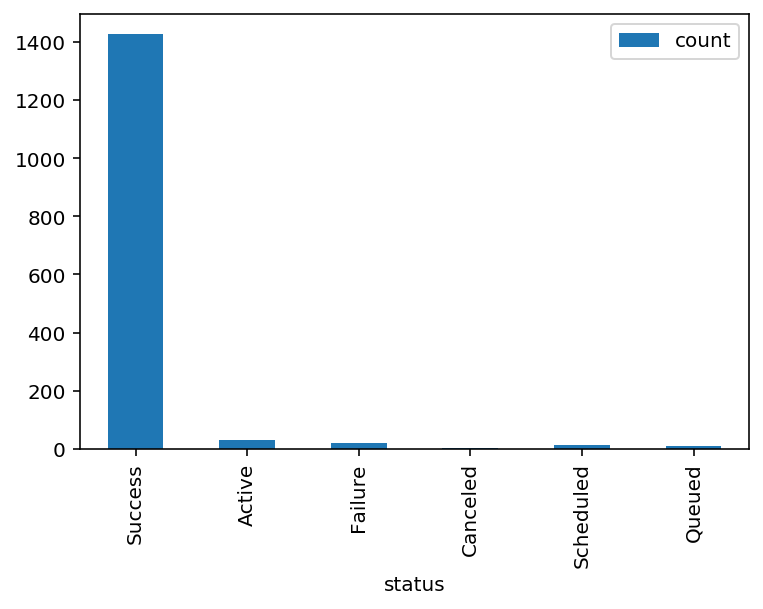

In [269]:
countDF_PD.plot.bar(x='status')

In [261]:
durationDF = newDF.filter(col('new_duration').isNotNull())
sumDF = durationDF.groupBy('objectType').sum()
sumPD = sumDF.toPandas()
durationDF_PD = durationDF.toPandas()
pandaDF = durationDF_PD.groupby(['objectType']).sum()

In [265]:
sumDF.show()

+-------------+------------------------+--------------------+-----------------+
|   objectType|sum(effectiveThroughput)|sum(dataTransferred)|sum(new_duration)|
+-------------+------------------------+--------------------+-----------------+
|  VolumeGroup|                 2443737|          3884800937|           3206.0|
|     OracleDb|                 6241525|           222566400|           4334.0|
|     HypervVm|                    null|                null|          19712.0|
|        Mssql|                61215470|           787871232|          50373.0|
|     VmwareVm|                48560971|         22153363122|           8111.0|
|ManagedVolume|                    null|                null|            235.0|
| ShareFileset|                    null|                null|             70.0|
+-------------+------------------------+--------------------+-----------------+



In [252]:
pandaDF.head(20)

,effectiveThroughput,dataTransferred,new_duration
objectType,,,
HypervVm,0.0,0.000000e+00,19712.0
ManagedVolume,0.0,0.000000e+00,235.0
Mssql,61215470.0,7.878712e+08,50373.0
OracleDb,6241525.0,2.225664e+08,4334.0
ShareFileset,0.0,0.000000e+00,70.0
VmwareVm,48560971.0,2.215336e+10,8111.0
VolumeGroup,2443737.0,3.884801e+09,3206.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12334e5f8>,
      dtype=object)

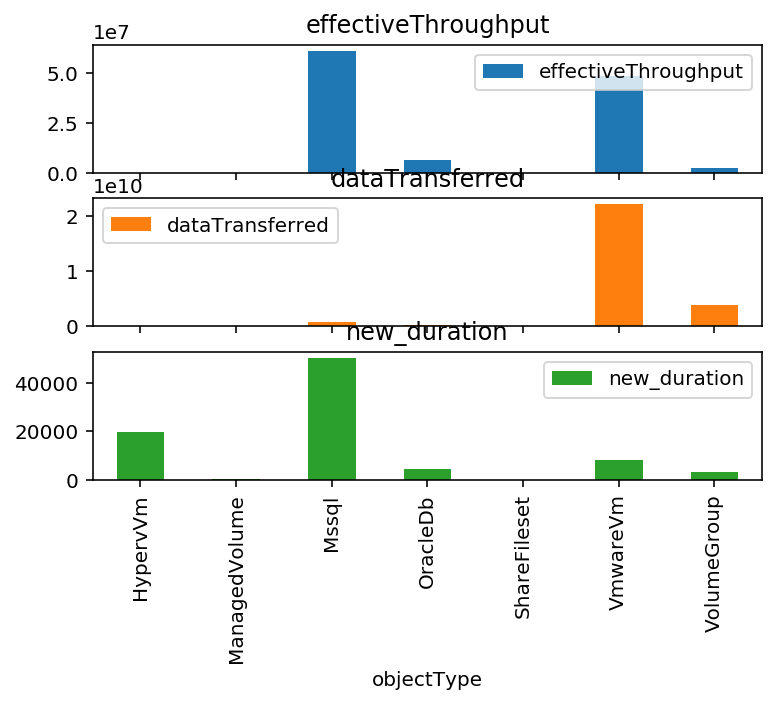

In [268]:
pandaDF.plot.bar(subplots=True)